In [2]:
import pandas as pd
from scipy.spatial.distance import cosine
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import umap
from adjustText import adjust_text
import re
from scipy.special import softmax
from collections import Counter

In [3]:
# embeddings = open('../../data/all_glove_gensim_word2vec.txt').readlines()

In [4]:
# embeddings = [line.strip() for line in embeddings]

In [5]:
# embedding_dict = {}
# for line in embeddings[1:]:
#     line = line.split()
#     embedding_dict[line[0]] = [float(item) for item in line[1:]]


In [6]:
# pickle.dump(embedding_dict, open('embedding_dict.p', 'wb'))

In [7]:
# embedding_dict = pickle.load(open('embedding_dict.p', 'rb'))

In [8]:
# df_srl_dem = pd.read_csv('srl_dem.tsv', sep='\t')

In [9]:
# df_srl_rep = pd.read_csv('srl_rep.tsv', sep='\t')

In [10]:
# len(df_srl_rep)

In [11]:
# df_srl_emb = df_srl_emb.sample(100000)

In [12]:
def get_args_df(df):   
    args_list_all = []
    for idx, row in df.iterrows():
        annotation = eval(row['Verb_annotation'])
        # extract verb and its embedding
        verb = annotation['verb'].lower()
        text = [t.lower() for t in eval(row['Text'])]
        verb_idx = text.index(verb)
        verb_emb = embedding_dict.get(verb, 0)

        # extract arg0
        arg0_idx = [idx for (idx, tag) in enumerate(annotation['tags']) if 'ARG0' in tag]
        # if arg0 is too long, may bring trouble
        arg0_emb = []
        if len(arg0_idx) > 0 and len(arg0_idx) <= 3:
            for idx in arg0_idx:
                emb = embedding_dict.get(text[idx], 0) 
                if emb != 0 and len(emb) == 300:
                    arg0_emb.append(emb)
            arg0_emb = np.asarray(arg0_emb)
            if arg0_emb.shape[0] > 1:
                # take the sum of word embeddings
                arg0_emb = np.sum(arg0_emb, axis=0)
                arg0_emb = np.expand_dims(arg0_emb, axis=0)
            try:
                arg0_emb = softmax(arg0_emb)
            except:
                pass
            arg0_tok = [text[idx] for idx in arg0_idx]
            arg0_tok = ' '.join([item for item in arg0_tok])

        else:
            arg0 = 'No_arg0'
            arg0_idx = -1
            arg0_emb = -1
            arg0_tok = 'No_arg0'

        arg1_idx = [idx for (idx, tag) in enumerate(annotation['tags']) if 'ARG1' in tag]
        arg1_emb = []
        if len(arg1_idx) > 0  and len(arg1_idx) <= 3:
            for idx in arg1_idx:
                emb = embedding_dict.get(text[idx], 0)
                if emb != 0 and len(emb) == 300:
                    arg1_emb.append(emb)
            arg1_emb = np.asarray(arg1_emb)
            if arg1_emb.shape[0] > 1:
                arg1_emb = np.sum(arg1_emb, axis=0)
                arg1_emb = np.expand_dims(arg1_emb, axis=0)
            try:
                arg1_emb = softmax(arg1_emb)
            except:
                pass

            arg1_tok = [text[idx] for idx in arg1_idx]
            arg1_tok = ' '.join([item for item in arg1_tok])


        else:
            arg1 = 'No_arg1'
            arg1_idx = -1
            arg1_emb = -1
            arg1_tok = 'No_arg1'
        if arg0_idx != -1 or arg1_idx != -1:
            args_list_all.append([verb, verb_idx, verb_emb, arg0_tok, arg0_idx, arg0_emb, arg1_tok, \
                                  arg1_idx, arg1_emb])
    return pd.DataFrame(args_list_all, columns=['Verb', 'Verb_idx', 'Verb_emb', 'Arg0_tok', 'Arg0_idx',\
                                               'Arg0_emb', 'Arg1_tok', 'Arg1_idx', 'Arg1_emb'])

In [13]:
# df_args_rep = get_args_df(df_srl_rep)
# pickle.dump(df_args_rep, open('rep_srl_parsed.p', 'wb'))

In [14]:
# df_args_dem = get_args_df(df_srl_dem)
# pickle.dump(df_args_dem, open('dem_srl_parsed.p', 'wb'))

In [15]:
df_args_dem = pickle.load(open('dem_srl_parsed.p', 'rb'))
df_args_rep = pickle.load(open('rep_srl_parsed.p', 'rb'))

In [16]:
len(df_args_rep)

358118

In [17]:
len(df_args_dem)

1342760

In [18]:
df_args_rep.head(2)

,Verb,Verb_idx,Verb_emb,Arg0_tok,Arg0_idx,Arg0_emb,Arg1_tok,Arg1_idx,Arg1_emb
0,is,4,"[-0.13593, 0.226247, -0.155218, 0.263514, 0.45...",No_arg0,-1,-1,the beauty that,"[1, 2, 3]","[[0.0019967582248604223, 0.0030668990752737374..."
1,tasked,33,"[0.095075, -0.361468, -0.10605, -0.078711, -0....",No_arg0,-1,-1,dnc fbi,"[31, 32]","[[0.007765591530827481, 0.0033374519706759163,..."


In [19]:
for col in ['Verb', 'Arg0_tok', 'Arg1_tok']:
    df_args_rep[col] = df_args_rep[col].apply(lambda x: str(x).encode('utf-8', 'replace').decode('utf-8'))

In [20]:
for col in ['Verb', 'Arg0_tok', 'Arg1_tok']:
    df_args_dem[col] = df_args_dem[col].apply(lambda x: str(x).encode('utf-8', 'replace').decode('utf-8'))

## Scatter plot

In [20]:
def extract_verb_agents(df, verb, arg_option):
    # look at the embeddings of a specific verb
    df_verb = df[df.Verb == verb]
    df_verb = df_verb[df_verb['Arg{}_idx'.format(arg_option)] != -1]

    df_verb_agg = df_verb.groupby('Arg{}_tok'.format(arg_option))\
            .head(1)[['Arg{}_tok'.format(arg_option), 'Arg{}_emb'.format(arg_option)]]
    df_verb_agg = df_verb_agg[df_verb_agg.apply(lambda row: row['Arg{}_emb'\
                                                                .format(arg_option)].shape[0] == 1, axis=1)]
    arr = np.asarray(df_verb_agg['Arg{}_emb'.format(arg_option)].tolist()).squeeze()
    print(arr.shape)
    dim = min(arr.shape[0]-10, 50)
    umap_reduc = umap.UMAP(n_components=dim).fit_transform(arr)
    pca_reduc = PCA(n_components=2).fit_transform(umap_reduc)
    df_verb_agg['emb_x'] = pca_reduc[:,0]
    df_verb_agg['emb_y'] = pca_reduc[:,1]
    return df_verb_agg

In [53]:
def plot_agent_verb(df, verb, arg_option, party):
    df_verb_agg = extract_verb_agents(df, verb, arg_option)
    x = df_verb_agg['emb_x'].tolist()
    y = df_verb_agg['emb_y'].tolist()
    text = df_verb_agg['Arg{}_tok'.format(arg_option)].tolist()
    plt.figure(figsize=(15, 15))
    plt.scatter(x,y, s=10)
    texts = [plt.text(x[idx], y[idx], text[idx], fontsize=12) for idx in range(len(text))]
#     adjust_text(texts, lim=20)#, expand_text=(1.02, 1.02), force_text=(0.75, 0.75), lim=20)
    plt.title('Arg {} of verb {}, {} party'.format(arg_option, verb, party))
#     plt.savefig('arg_{}_verb_{}_party_{}.png'.format(arg_option, verb, party), format='png')

(831, 300)


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8294 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8297 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8294 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_a

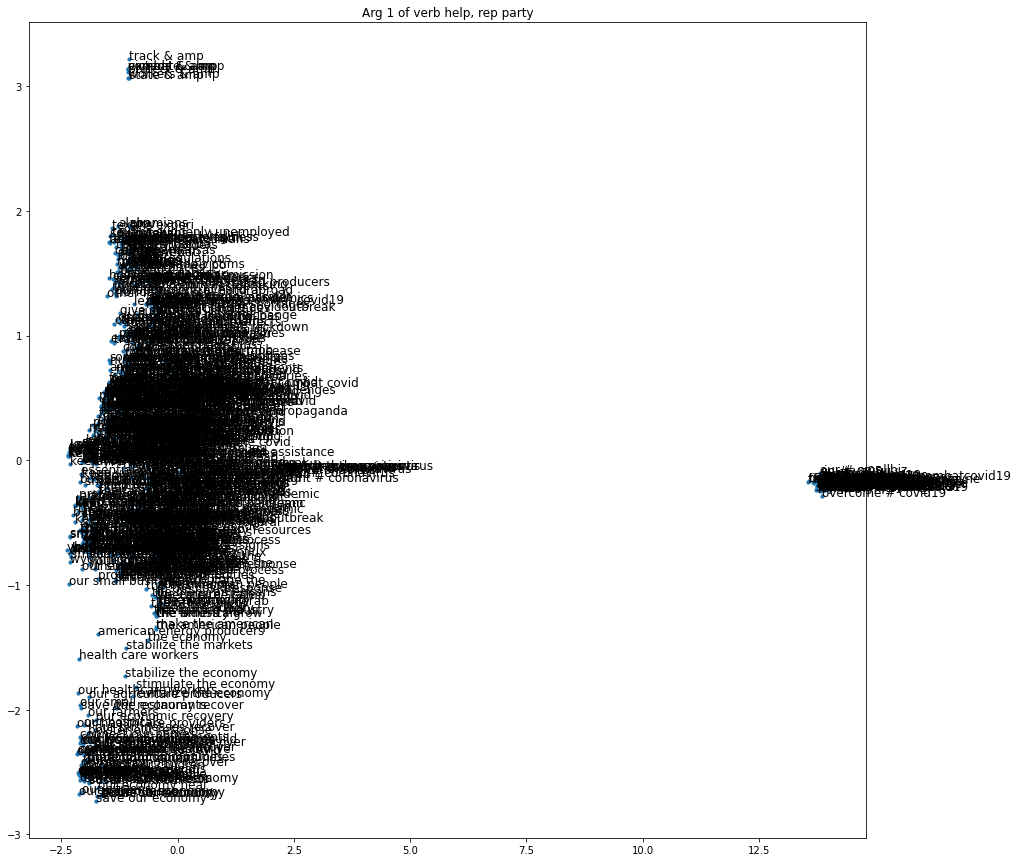

In [54]:
plot_agent_verb(df_args_rep, 'help', 1, 'rep')

## Bar plot

In [55]:
def verb_agent_cnt(df, verb, arg_option):
    # look at the embeddings of a specific verb
    tok_col = 'Arg{}_tok'.format(arg_option)
    df_verb =df[df.Verb == verb]
    df_verb = df_verb[df_verb[tok_col] != -1]
    cnt = df_verb[tok_col].value_counts().to_frame().reset_index().head(10)
    cnt.columns=[tok_col, 'Frequency']
    cnt = cnt[cnt[tok_col] != 'No_arg{}'.format(arg_option)]
    return cnt

In [56]:
def plot_bar(df, verb, party):
    verb_arg0 = verb_agent_cnt(df, verb, 0)
    verb_arg1 = verb_agent_cnt(df, verb, 1)
    if party == 'dem':
        color = 'blue'
    elif party == 'rep':
        color = 'red'

    fig, ax1 = plt.subplots(figsize=(12,5))

    left_max = verb_arg0['Frequency'].head(1).values[0]
    ax1.yaxis.tick_left()
    x1 = np.arange(len(verb_arg0))
    ax1.barh(x1, verb_arg0['Frequency'].tolist(),color=color)
    ax1.set_yticks(x1)
    ax1.set_yticklabels(verb_arg0['Arg0_tok'], fontsize=15)
    ax1.set_xlim(0, left_max*2)
    ax1.set_ylim(-1,9)
#     ax1.set_xticks(range(0,left_max,int(left_max/10)))
    ax1.spines['bottom'].set_bounds(0,left_max)
    ax1.spines['top'].set_bounds(0,0)

    right_max = verb_arg1['Frequency'].head(1).values[0]
    ax2 = ax1.twiny()
    ax2.invert_xaxis()
    ax2.yaxis.tick_right()

    ax2.barh(np.arange(len(verb_arg0)), verb_arg1['Frequency'].tolist()[::-1],color=color)
    ax2.yaxis.set_label_position('right')
    ax2.set_xlim(right_max*2.5)
    ax2.spines['bottom'].set_bounds(0,0)
    ax2.spines['top'].set_bounds(0,right_max)

    
    ax3 = ax2.twinx()
    ax3.yaxis.tick_right()
    ax3.set_yticks(x1)
    ax3.set_yticklabels(verb_arg1['Arg1_tok'], fontsize=15)
    ax3.set_ylim(-1,9)
    ax3.spines['bottom'].set_bounds(0,0)
    ax3.spines['top'].set_bounds(0,0)

    ax1.annotate('Arg0',fontsize=15, xy=(0.3, 0.515), xycoords='axes fraction', xytext=(0.2, 0.5), 
            arrowprops=dict(arrowstyle="->", color='r'))
    ax1.text(0.35, 0.5, 'Verb: {}'.format(verb), fontsize=15, transform=ax1.transAxes)
    ax1.annotate('Arg1',fontsize=15, xy=(0.55, 0.515), xycoords='axes fraction', xytext=(0.6, 0.5), 
            arrowprops=dict(arrowstyle="<-", color='r'))

#     ax3.set_title('Verb: {}'.format(verb))
    plt.tight_layout()

#     plt.save fig('{}_{}.pdf'.format(verb, party), format='pdf')

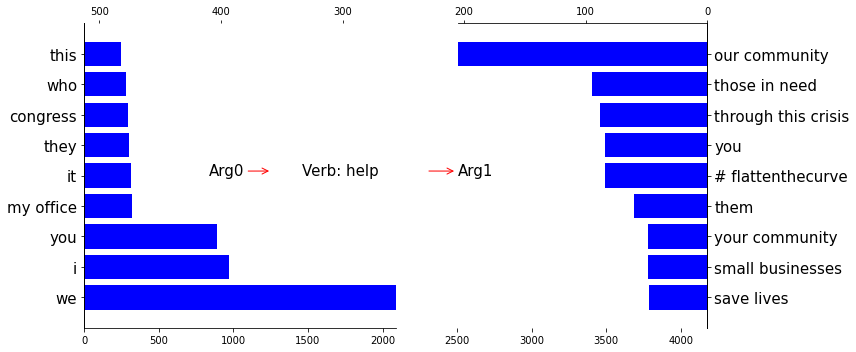

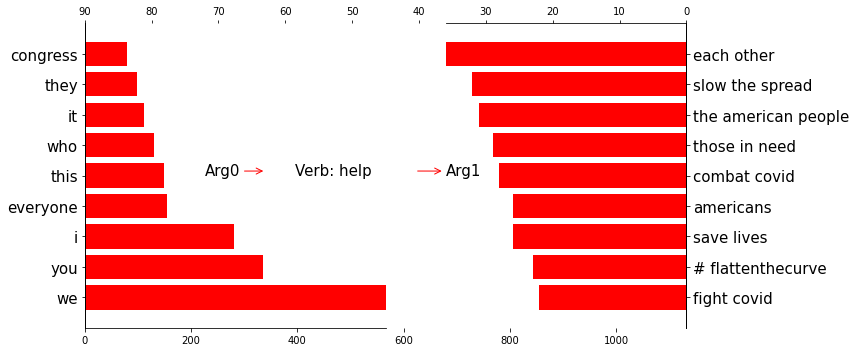

In [57]:
plot_bar(df_args_dem, 'help', 'dem')
plot_bar(df_args_rep, 'help', 'rep')

In [58]:
# plot_bar(df_args_dem, 'working', 'dem')
# plot_bar(df_args_rep, 'working', 'rep')

In [59]:
# plot_bar(df_args_dem, 'want', 'dem')
# plot_bar(df_args_rep, 'want', 'rep')

## Us vs them (arrows fig)

In [21]:
df_args_dem.head(2)

,Verb,Verb_idx,Verb_emb,Arg0_tok,Arg0_idx,Arg0_emb,Arg1_tok,Arg1_idx,Arg1_emb
0,had,1,"[-0.069991, 0.188146, 0.460361, 0.014143, -0.2...",we,[0],"[[0.002591727002208291, 0.0027220532033485232,...",No_arg1,-1,-1
1,thinking,17,"[-0.03483, 0.082901, -0.056682, -0.102523, 0.4...",we,[15],"[[0.002591727002208291, 0.0027220532033485232,...",No_arg1,-1,-1


In [22]:
def fix_arg0_verb(df, arg0_list, verb_list):
    # hold the verb and arg0s constant, find the most frequent arg1s
    df_verb =df[df.Verb.isin(verb_list)]
    if len(arg0_list) == 1:
        df_verb = df_verb[df_verb.Arg0_tok == arg0_list[0]]
    else:
        df_verb = df_verb[df_verb.Arg0_tok.isin(arg0_list)]
    df_verb = df_verb[df_verb['Arg1_idx'] != -1]

    cnt = df_verb['Arg1_tok'].value_counts().to_frame().reset_index().head(25)
    cnt.columns=['Arg1_tok', 'Frequency']
    return cnt

In [23]:
dem_them = ['democrat', 'democratic', 'dems', 'housedemocrats', 'reddemocrats','democraticled',
            'pelosi','speakerpelosi', 'nancy pelosi',  'chuck schumer', 'ralph northam', 
            'ayanna pressley','gwen moore', 'senatedems', ]

In [24]:
rep_them = ['gop', 'republicans', 'republican', 'president', 'trump','donald trump', 'patrick mchenry','larry hogan',
           'mitch mcconnell','mcconnell', ]

In [25]:
us_list = ['i', 'we', 'our', 'us', 'ours']
them_list = ['they', 'their', 'theirs', 'democrats', 'republicans']

In [26]:
# vlist = ['hold', 'holding', 'hosting', 'join', 'joined', 'joining', 'talk', 'spoke', 'discuss', 'sent']

In [27]:
# vlist = ['have', 'has', 'been', 'had']

In [28]:
# vlist = ['make', 'made', 'making', 'needs']

In [29]:
vlist = ['want']

In [30]:
fix_arg0_verb(df_args_dem ,us_list, vlist)

,Arg1_tok,Frequency
0,answers,30
1,to be clear,23
2,a healthy earth,20
3,what,18
4,the # eranow,8
5,to change that,8
6,to see,8
7,the last thing,7
8,the future,7
9,to know,7


In [139]:
fix_arg0_verb(df_args_rep ,us_list, vlist)

,Arg1_tok,Frequency
0,what,9
1,to help,8
2,to do,8
3,nothing,7
4,ev,4
5,everyone tested,4
6,no quid,3
7,all,3
8,to,3
9,t,3


In [140]:
fix_arg0_verb(df_args_rep ,them_list+dem_them, vlist)

,Arg1_tok,Frequency
0,me to d,4
1,to mask massi,4
2,another week,3
3,blue masks,3
4,you to,3
5,a 9th,3
6,all,3
7,the president,2
8,to,2
9,you to contro,2


In [141]:
fix_arg0_verb(df_args_dem ,them_list+rep_them, vlist)

,Arg1_tok,Frequency
0,all,12
1,whatever,8
2,detailed,8
3,one,7
4,quality health,6
5,a fair trial,5
6,to change that,4
7,a taxpayer,4
8,a bailout,4
9,you to vote,4


In [44]:
# df_args_rep.Verb.value_counts().head(50)

In [116]:
df = pickle.load(open('../../data/all_tweet_texts_rep.p', 'rb'))

In [117]:
for line in df[df.Text.str.contains('voted')].Text.tolist():
    print(line)

Because of MAIL-IN BALLOTS, 2020 will be the most RIGGED Election in our nations history - unless this stupidity is ended. We voted during World War One &amp; World War Two with no problem, but now they are using Covid in order to cheat by using Mail-Ins!
The Republican Party has not yet voted on a Platform. No rush. I prefer a new and updated Platform, short form, if possible.
This wk the bipartisan Inspector General Access Act of 2019 was voted out of the Judiciary Committee. I am a cosponsor of the bill. Before the vote I told my colleagues how important it is for inspectors general to… 
2day Russell Vought 2b director of OMB at WH was voted out of Budget Cmte. It’s important for him to provide ldrship needed to make sure taxpayer $$$ are used efficiently+ accountably+ transparently&amp; oversight is at forefront of the office. He’s also pt person to reduce govt regs
2day on my run I was stopped by a retired union member +lifelong Democrat from my neighborhood who said the 1st repub

In [118]:
df.head(2)

,Text,Time
0,RT @WhiteHouse: LIVE: President @realDonaldTru...,2020-07-22 21:51:18
1,RT @TeamTrump: President @realDonaldTrump on O...,2020-07-22 20:45:37


## Shared patients between parties

In [31]:
vlist = ['help']

In [163]:
def find_share_pat(vlist):
    dem_v = fix_arg0_verb(df_args_dem, them_list+us_list, vlist)
    rep_v = fix_arg0_verb(df_args_rep ,them_list+us_list, vlist)
    shared = pd.merge(dem_v, rep_v, on='Arg1_tok', how='inner')
    try:
        return len(shared)/(len(dem_v)+len(rep_v)), shared
    except:
        return 'N/A', 'N/A'

In [146]:
find_share_pat(vlist)

(0.14,
             Arg1_tok  Frequency_x  Frequency_y
 0         save lives           29            2
 1         each other           17            3
 2                you           17            2
 3  # flattenthecurve           13            5
 4               what            9            6
 5       our district            8            7
 6      those in need            7            2)

In [45]:
dem_verb_freq = Counter(df_args_dem.Verb.tolist())
dem_verb_freq = [item[0] for item in dem_verb_freq.most_common(100)]

In [47]:
rep_verb_freq = Counter(df_args_rep.Verb.tolist())
rep_verb_freq = [item[0] for item in rep_verb_freq.most_common(100)]

In [55]:
all_verb_freq = list(set(dem_verb_freq + rep_verb_freq))

In [57]:
len(all_verb_freq)

125

In [164]:
shared_cnt = {}
for verb in all_verb_freq:
    res, _ = find_share_pat([verb])
    if res != 'N/A':
        shared_cnt[verb] = res

In [165]:
shared_cnt

{'remember': 0.12,
 'know': 0.14,
 'let': 0.12244897959183673,
 'honor': 0.16,
 'read': 0.03125,
 'regarding': 0.0,
 'expand': 0.14,
 'encourage': 0.16,
 'prevent': 0.12,
 'support': 0.26,
 'discuss': 0.08,
 'voted': 0.18,
 'live': 0.10526315789473684,
 'use': 0.08,
 'hold': 0.12,
 'visit': 0.0,
 'sent': 0.1276595744680851,
 'provide': 0.16,
 'hear': 0.1,
 'pass': 0.14,
 'protect': 0.22,
 'working': 0.06,
 'received': 0.02,
 'doing': 0.34,
 'join': 0.08,
 'passed': 0.14,
 'give': 0.06,
 'had': 0.06,
 'fight': 0.26,
 'urging': 0.24,
 'paid': 0.125,
 'face': 0.12,
 'vote': 0.16,
 'has': 0.0,
 'made': 0.12,
 'receive': 0.02,
 'work': 0.08,
 'led': 0.14,
 'said': 0.14285714285714285,
 'can': 0.18,
 'done': 0.1956521739130435,
 'helping': 0.045454545454545456,
 'fighting': 0.12,
 'hope': 0.12,
 'combat': 0.28,
 'have': 0.1,
 'learn': 0.05128205128205128,
 'confirmed': 0.0,
 'provides': 0.0,
 'stay': 0.0,
 'hosting': 0.12,
 'lost': 0.1,
 'save': 0.16,
 'make': 0.18,
 'calling': 0.08,
 'act':

In [166]:
# shared_cnt_df = pd.DataFrame({'verb': all_verb_freq, 'shared_cnt': shared_cnt})

In [168]:
for k in sorted(shared_cnt, key=shared_cnt.get, reverse=True):
    print(k, shared_cnt[k])

be 0.5
need 0.36
do 0.36
doing 0.34
combat 0.28
take 0.28
get 0.28
support 0.26
fight 0.26
urging 0.24
play 0.22857142857142856
protect 0.22
keep 0.22
pay 0.21428571428571427
respond 0.2
needs 0.2
done 0.1956521739130435
voted 0.18
can 0.18
make 0.18
say 0.18
honor 0.16
encourage 0.16
provide 0.16
vote 0.16
save 0.16
put 0.16
taking 0.16
said 0.14285714285714285
know 0.14
expand 0.14
pass 0.14
passed 0.14
led 0.14
address 0.14
stop 0.14
deserve 0.14
find 0.14
help 0.14
slow 0.12903225806451613
sent 0.1276595744680851
paid 0.125
let 0.12244897959183673
remember 0.12
prevent 0.12
hold 0.12
face 0.12
made 0.12
fighting 0.12
hope 0.12
hosting 0.12
look 0.12
bring 0.12
introduced 0.12
want 0.12
live 0.10526315789473684
hear 0.1
have 0.1
lost 0.1
needed 0.1
call 0.1
see 0.1
making 0.1
signed 0.1
keeping 0.1
go 0.09090909090909091
stand 0.08333333333333333
talk 0.08333333333333333
discuss 0.08
use 0.08
join 0.08
work 0.08
calling 0.08
providing 0.08
continue 0.08
thank 0.08
facing 0.08
loved 

In [156]:
find_share_pat(['come'])

(0.0,
 Empty DataFrame
 Columns: [Arg1_tok, Frequency_x, Frequency_y]
 Index: [])

In [153]:
fix_arg0_verb(df_args_dem, them_list+us_list, ['meet'])

,Arg1_tok,Frequency
0,this moment,32
1,with,9
2,this challenge,8
3,demand,7
4,the challenge,6
5,the moment,6
6,you,6
7,them,4
8,their basic needs,4
9,with many constituents,4


In [173]:
x = []
y = []
sample = sorted(shared_cnt, key=shared_cnt.get, reverse=True)[0:10]
sample += sorted(shared_cnt, key=shared_cnt.get, reverse=True)[-10:]
for k in sample:
    x.append(k)
    y.append(shared_cnt[k])

Text(0.5, 1.0, 'Percentage of shared patients')

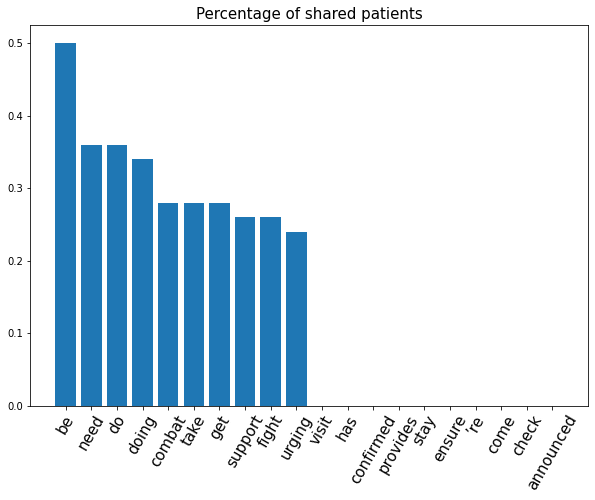

In [180]:
plt.figure(figsize=(10, 7))
plt.bar(range(0, len(y)), y)
plt.xticks(range(0, len(y)), x, rotation=60, fontsize=15)
# plt.xlabel('Verb', fontsize=15)
plt.title('Percentage of shared patients', fontsize=15)

## Largest difference

In [76]:
rep_v = df_args_rep.Verb.value_counts().head(50).index.tolist()
dem_v = df_args_dem.Verb.value_counts().head(50).index.tolist()

In [77]:
df_args_dem.head(2)

,Verb,Verb_idx,Verb_emb,Arg0_tok,Arg0_idx,Arg0_emb,Arg1_tok,Arg1_idx,Arg1_emb
0,had,1,"[-0.069991, 0.188146, 0.460361, 0.014143, -0.2...",we,[0],"[[0.002591727002208291, 0.0027220532033485232,...",No_arg1,-1,-1
1,thinking,17,"[-0.03483, 0.082901, -0.056682, -0.102523, 0.4...",we,[15],"[[0.002591727002208291, 0.0027220532033485232,...",No_arg1,-1,-1


In [78]:
arg1_dem = df_args_dem[df_args_dem['Arg1_tok'] != 'No_arg1']
arg1_dem = arg1_dem['Arg1_tok'].tolist()
arg1_dem = Counter(arg1_dem)
arg1_dem = {x: count for x, count in arg1_dem.items() if count > 9}

In [79]:
arg1_dem

{'we': 20616,
 'you': 30615,
 'scammers': 48,
 'they': 7527,
 'risk': 108,
 'help & amp': 10,
 '# covid19': 1971,
 '# smallbiz': 23,
 'young people': 135,
 'reading': 32,
 'a new website': 15,
 'more': 4269,
 'power': 191,
 'the # caresact': 276,
 'enough': 420,
 'with congress': 14,
 'problem': 43,
 'all of them': 22,
 'colleagues': 67,
 'them': 6037,
 'taxes': 496,
 'sick leave': 948,
 'these': 1040,
 'everyone': 1773,
 'good things': 12,
 'the faith': 41,
 'the opportunity': 26,
 'everything possible': 148,
 'i': 32557,
 '#': 181,
 'money': 772,
 'to hear this': 15,
 'this': 18757,
 'it': 29236,
 'lives': 3799,
 'support them': 12,
 'financial ruin': 10,
 'that': 7468,
 'our health system': 33,
 'hospitals': 201,
 'more help': 112,
 'high': 27,
 'additional aid': 25,
 'time': 873,
 'leaders': 82,
 'things done': 48,
 'things': 558,
 'small businesses': 1355,
 'he': 4109,
 'their part': 242,
 'the best': 100,
 '# passover': 120,
 'hope': 173,
 'the situation': 242,
 'pres trump': 24,

In [80]:
arg1_rep = df_args_rep[df_args_rep['Arg1_tok'] != 'No_arg1']
 

In [81]:
len(arg1_rep)

228426

In [82]:
arg1_dem

{'we': 20616,
 'you': 30615,
 'scammers': 48,
 'they': 7527,
 'risk': 108,
 'help & amp': 10,
 '# covid19': 1971,
 '# smallbiz': 23,
 'young people': 135,
 'reading': 32,
 'a new website': 15,
 'more': 4269,
 'power': 191,
 'the # caresact': 276,
 'enough': 420,
 'with congress': 14,
 'problem': 43,
 'all of them': 22,
 'colleagues': 67,
 'them': 6037,
 'taxes': 496,
 'sick leave': 948,
 'these': 1040,
 'everyone': 1773,
 'good things': 12,
 'the faith': 41,
 'the opportunity': 26,
 'everything possible': 148,
 'i': 32557,
 '#': 181,
 'money': 772,
 'to hear this': 15,
 'this': 18757,
 'it': 29236,
 'lives': 3799,
 'support them': 12,
 'financial ruin': 10,
 'that': 7468,
 'our health system': 33,
 'hospitals': 201,
 'more help': 112,
 'high': 27,
 'additional aid': 25,
 'time': 873,
 'leaders': 82,
 'things done': 48,
 'things': 558,
 'small businesses': 1355,
 'he': 4109,
 'their part': 242,
 'the best': 100,
 '# passover': 120,
 'hope': 173,
 'the situation': 242,
 'pres trump': 24,

In [83]:
us_list = ['I', 'we', 'our', 'us', 'ours']
# them_list = ['they', 'their', 'theirs', 'democrats', 'republicans']


In [85]:
arg_us_them_dem = []
for arg in arg1_dem[0:1000]:
    df_t = df_args_dem[df_args_dem['Arg1_tok'] == arg]
    df_t_us = df_t[df_t['Arg0_tok'].isin(us_list)]
    df_t_them = df_t[(df_t['Arg0_tok'].isin(rep_them)) ]
    arg_us_them_dem.append([arg, len(df_t_us), len(df_t_them)])


TypeError: unhashable type: 'slice'

In [ ]:
arg_us_them_dem_df = pd.DataFrame(arg_us_them_dem)
arg_us_them_dem_df.columns = ['Arg1_tok', 'us_freq', 'them_freq']

In [ ]:
arg_us_them_dem_df.head(10)

In [ ]:
arg_us_them_dem_df['diff'] = arg_us_them_dem_df['us_freq'] - arg_us_them_dem_df['them_freq']

In [ ]:
arg_us_them_dem_df.sort_values(by='diff', ascending=False).head(20)

In [ ]:
arg_us_them_dem_df.sort_values(by='diff', ascending=False).tail(20)

In [ ]:
arg_us_them_rep = []
for arg in arg1_rep:
    df_t = df_args_rep[df_args_rep['Arg1_tok'] == arg]
    df_t_us = df_t[df_t['Arg0_tok'].isin(us_list)]
    df_t_them = df_t[(df_t['Arg0_tok'].isin(dem_them)) ]
    arg_us_them_rep.append([arg, len(df_t_us), len(df_t_them)])


In [ ]:
arg_us_them_rep_df = pd.DataFrame(arg_us_them_rep)
arg_us_them_rep_df.columns = ['Arg1_tok', 'us_freq', 'them_freq']

In [ ]:
arg_us_them_rep_df['diff'] = arg_us_them_rep_df['us_freq'] - arg_us_them_rep_df['them_freq']

In [ ]:
arg_us_them_rep_df.sort_values(by='diff', ascending=False).head(20)

In [ ]:
arg_us_them_rep_df.sort_values(by='diff', ascending=False).tail(20)

## Top frequent agents & patients

In [86]:
df_args_rep.head(2)

,Verb,Verb_idx,Verb_emb,Arg0_tok,Arg0_idx,Arg0_emb,Arg1_tok,Arg1_idx,Arg1_emb
0,is,4,"[-0.13593, 0.226247, -0.155218, 0.263514, 0.45...",No_arg0,-1,-1,the beauty that,"[1, 2, 3]","[[0.0019967582248604223, 0.0030668990752737374..."
1,tasked,33,"[0.095075, -0.361468, -0.10605, -0.078711, -0....",No_arg0,-1,-1,dnc fbi,"[31, 32]","[[0.007765591530827481, 0.0033374519706759163,..."


In [76]:
def get_top_args(df):
    arg0 = df['Arg0_tok'].tolist()
    arg0 = Counter(arg0)
    top_arg0 = sorted(arg0, key=arg0.get, reverse=True)[0:10]
    top_arg0 = df[df['Arg0_tok'].isin(top_arg0)].drop_duplicates(subset='Arg0_tok')
    top_arg0 = top_arg0[top_arg0['Arg0_idx'] != -1]
    temp = []
    for idx, row in top_arg0.iterrows():
        if row['Arg0_emb'].shape[0] != 0:
            temp.append(row)
    top_arg0 = pd.DataFrame(temp)
    top_arg0['Frequency'] = top_arg0['Arg0_tok'].map(arg0)
    top_arg0 = top_arg0.sort_values(by='Frequency')

    arg1 = df['Arg1_tok'].tolist()
    arg1 = Counter(arg1)
    top_arg1 = sorted(arg1, key=arg1.get, reverse=True)[0:10]
    top_arg1 = df[df['Arg1_tok'].isin(top_arg1)].drop_duplicates(subset='Arg1_tok')
    top_arg1 = top_arg1[top_arg1['Arg1_idx'] != -1]
    temp = []
    for idx, row in top_arg1.iterrows():
        if row['Arg1_emb'].shape[0] != 0:
            temp.append(row)
    top_arg1 = pd.DataFrame(temp)
    top_arg1['Frequency'] = top_arg1['Arg1_tok'].map(arg1)
    top_arg1 = top_arg1.sort_values(by='Frequency')

    return top_arg0, top_arg1

In [77]:
top_arg0_rep, top_arg1_rep = get_top_args(df_args_rep)

10


In [78]:
top_arg0_dem, top_arg1_dem = get_top_args(df_args_dem)

10


In [75]:
top_arg1_rep.head()

,Verb,Verb_idx,Verb_emb,Arg0_tok,Arg0_idx,Arg0_emb,Arg1_tok,Arg1_idx,Arg1_emb,Frequency
4027,post,6,"[-0.132736, 0.249182, -0.121275, -0.159282, -0...",@cdcgov,[0],[],the,[7],"[[0.0030831606927924403, 0.0024929238779567552...",144
5051,host,5,"[0.136974, -0.146767, 0.384878, -0.53585, -0.1...",i,[3],"[[0.0022316546260752494, 0.002160149203758373,...",a news conference,"[6, 7, 8]","[[0.0020705481536352436, 0.0013132636577255082...",145
4705,flatten,14,"[-0.69318, 0.320691, 0.264642, 0.445964, 0.321...",america,[12],"[[0.0017869446585137057, 0.003404269117438289,...",the curve,"[15, 16]","[[0.001815137156665755, 0.002216514757660349, ...",147
7361,urged,1,"[0.451385, -0.084173, -0.151155, 0.117291, -0....",i,[0],"[[0.0022316546260752494, 0.002160149203758373,...",my colleagues,"[2, 3]","[[0.002142032946410288, 0.0014362554618829481,...",150
199,taking,9,"[-0.50852, -0.055029, -0.427942, -0.074495, -0...",4 companies,"[0, 1]","[[0.002458352969650661, 0.006301663216540355, ...",advantage,[10],"[[0.0020838833978992647, 0.002661088291385755,...",153


In [15]:
umap_reduc = umap.UMAP(min_dist=0.0,n_neighbors=5).fit_transform(np.array(\
                                                                top_arg_rep['Arg0_emb'].tolist()).squeeze())
top_arg_rep['umap_emb_x'] = umap_reduc[:,0]
top_arg_rep['umap_emb_y'] = umap_reduc[:,1]

NameError: name 'top_arg_rep' is not defined

In [ ]:
plt.figure(figsize=(10, 8))
x = top_arg_rep['umap_emb_x'].tolist()
y = top_arg_rep['umap_emb_y'].tolist()
text = top_arg_rep['Arg0_tok'].tolist()
plt.scatter(x,y, s=10, c='blue')
texts = [plt.text(x[idx], y[idx], text[idx], fontsize=12, c='blue') for idx in range(len(text))]

# x_rep = df_rep['umap_emb_x'].tolist()
# y_rep = df_rep['umap_emb_y'].tolist()
# text_rep = df_rep['Arg{}_tok'.format(arg_option)].tolist()
# plt.scatter(x_rep,y_rep, s=10, c='red')
# texts_rep = [plt.text(x_rep[idx], y_rep[idx], text_rep[idx], fontsize=12, c='red') for idx in range(len(text_rep))]

# plt.title('Arg {} of verb {}'.format(arg_option, verb))
all_texts = texts# + texts_rep
adjust_text(all_texts)#, expand_text=(1.02, 1.02), force_text=(0.75, 0.75), lim=20)
plt.title('Rep arg0')
# plt.savefig('arg_{}_verb_{}_both_party.png'.format(arg_option, verb), format='png')

In [85]:
top_arg1_rep

,Verb,Verb_idx,Verb_emb,Arg0_tok,Arg0_idx,Arg0_emb,Arg1_tok,Arg1_idx,Arg1_emb,Frequency
597,encourage,19,"[-0.135012, -0.143873, -0.090635, -0.208849, 0...",i,[18],"[[0.0022316546260752494, 0.002160149203758373,...",all,[20],"[[0.004457115004967434, 0.0037123819173742255,...",391
375,need,26,"[0.131859, -0.329831, 0.062535, 0.187029, 0.48...",taxpayers,[25],"[[0.004045390759606627, 0.0029095550012617857,...",relief,[27],"[[0.004623259454041256, 0.0019964187807386302,...",395
346,join,2,"[0.351014, -0.205603, 0.038122, -0.014607, 0.0...",dems,[0],"[[0.003352129803249948, 0.0020714956984408165,...",us,[3],"[[0.0033199406276050018, 0.0028837568316440196...",492
481,presented,1,"[-0.678362, 0.438838, -0.250154, 0.388207, -0....",iowans,[0],"[[0.0025179888421729395, 0.00471245735966546, ...",me,[2],"[[0.0024121880323228592, 0.002873581705906875,...",513
95,echo,1,"[-0.697105, -0.266437, -0.181732, -0.098392, -...",i,[0],"[[0.0022316546260752494, 0.002160149203758373,...",this,[2],"[[0.002951748376334912, 0.002174264974651749, ...",574
637,support,15,"[0.066131, -0.344894, -0.050744, -0.065526, 0....",we,[11],"[[0.002591727002208291, 0.0027220532033485232,...",them,[16],"[[0.0028924522300110486, 0.002032175034084909,...",761
756,connecting,8,"[-0.031008, -0.272265, 0.994761, -0.004654, -0...",a phone call,"[5, 6, 7]","[[0.0017236355728087443, 0.0019495172254182789...",you,[9],"[[0.0016557294507455345, 0.004215265873760498,...",891
220108,have,17,"[-0.037825, -0.086795, -0.003929, -0.34134, -0...",a person,"[13, 14]","[[0.0014978534405033878, 0.0019001181026471936...",covid,[18],"[[0.0032927388779860935, 0.0015970859766981488...",1099
205,need,28,"[0.131859, -0.329831, 0.062535, 0.187029, 0.48...",farmers who,"[26, 27]","[[0.004825395372512119, 0.0030730227119356813,...",it,[29],"[[0.0038805358372917234, 0.0035253236459191722...",1703
11,know,34,"[-0.173154, 0.181049, -0.546561, 0.009762, 0.5...",mueller,[33],"[[0.0038555891151006386, 0.0022866750375142245...",what,[31],"[[0.002570881966341957, 0.0033803052551789193,...",2150


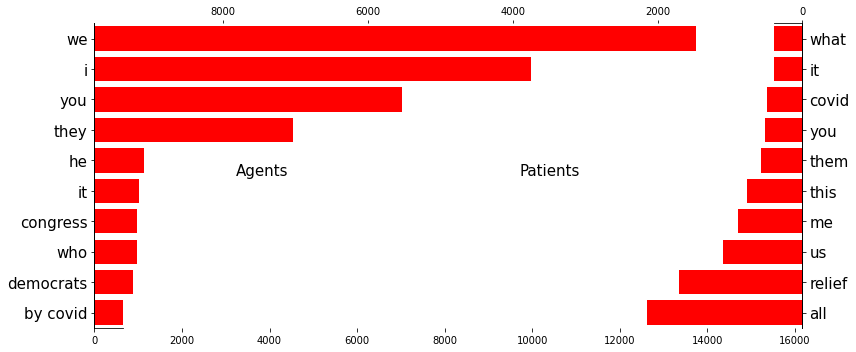

In [107]:
fig, ax1 = plt.subplots(figsize=(12,5))

left_max = top_arg0_rep['Frequency'].head(1).values[0]
ax1.yaxis.tick_left()
x1 = np.arange(len(top_arg0_rep))
ax1.barh(x1, top_arg0_rep['Frequency'].tolist(),color='red')
ax1.set_yticks(x1)
ax1.set_yticklabels(top_arg0_rep['Arg0_tok'], fontsize=15)
ax1.set_xlim(0, left_max*25)
ax1.set_ylim(-0.5,9.5)
#     ax1.set_xticks(range(0,left_max,int(left_max/10)))
ax1.spines['bottom'].set_bounds(0,left_max)
ax1.spines['top'].set_bounds(0,0)

right_max = top_arg1_rep['Frequency'].head(1).values[0]
ax2 = ax1.twiny()
ax2.invert_xaxis()
ax2.yaxis.tick_right()

ax2.barh(np.arange(len(top_arg1_rep)), top_arg1_rep['Frequency'].tolist()[::-1],color='red')
ax2.yaxis.set_label_position('right')
ax2.set_xlim(right_max*25)
ax2.spines['bottom'].set_bounds(0,0)
ax2.spines['top'].set_bounds(0,right_max)


ax3 = ax2.twinx()
ax3.yaxis.tick_right()
ax3.set_yticks(x1)
ax3.set_yticklabels(top_arg1_rep['Arg1_tok'], fontsize=15)
ax3.set_ylim(-0.5,9.5)
ax3.spines['bottom'].set_bounds(0,0)
ax3.spines['top'].set_bounds(0,0)

ax1.annotate('Agents',fontsize=15, xy=(0.3, 0.515), xycoords='axes fraction', xytext=(0.2, 0.5))
# ax1.text(0.35, 0.5, 'Verb: {}'.format(verb), fontsize=15, transform=ax1.transAxes)
ax1.annotate('Patients',fontsize=15, xy=(0.55, 0.515), xycoords='axes fraction', xytext=(0.6, 0.5))

# ax3.set_title('Verb: {}'.format(verb))
plt.tight_layout()

plt.savefig('rep_args.pdf', format='pdf')

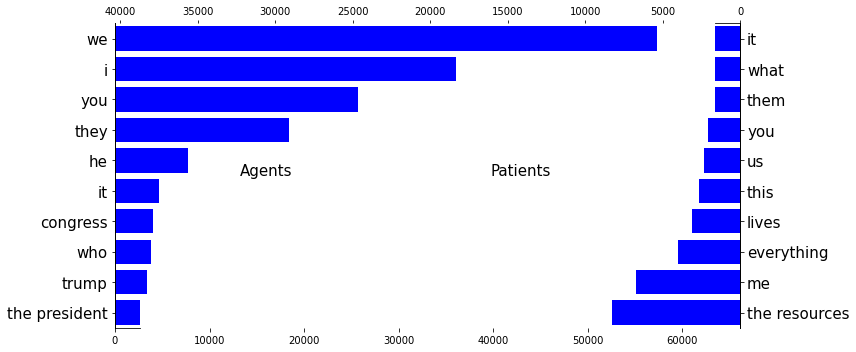

In [108]:
fig, ax1 = plt.subplots(figsize=(12,5))

left_max = top_arg0_dem['Frequency'].head(1).values[0]
ax1.yaxis.tick_left()
x1 = np.arange(len(top_arg0_dem))
ax1.barh(x1, top_arg0_dem['Frequency'].tolist(),color='blue')
ax1.set_yticks(x1)
ax1.set_yticklabels(top_arg0_dem['Arg0_tok'], fontsize=15)
ax1.set_xlim(0, left_max*25)
ax1.set_ylim(-0.5,9.5)
#     ax1.set_xticks(range(0,left_max,int(left_max/10)))
ax1.spines['bottom'].set_bounds(0,left_max)
ax1.spines['top'].set_bounds(0,0)

right_max = top_arg1_dem['Frequency'].head(1).values[0]
ax2 = ax1.twiny()
ax2.invert_xaxis()
ax2.yaxis.tick_right()

ax2.barh(np.arange(len(top_arg1_dem)), top_arg1_dem['Frequency'].tolist()[::-1],color='blue')
ax2.yaxis.set_label_position('right')
ax2.set_xlim(right_max*25)
ax2.spines['bottom'].set_bounds(0,0)
ax2.spines['top'].set_bounds(0,right_max)


ax3 = ax2.twinx()
ax3.yaxis.tick_right()
ax3.set_yticks(x1)
ax3.set_yticklabels(top_arg1_dem['Arg1_tok'], fontsize=15)
ax3.set_ylim(-0.5,9.5)
ax3.spines['bottom'].set_bounds(0,0)
ax3.spines['top'].set_bounds(0,0)

ax1.annotate('Agents',fontsize=15, xy=(0.3, 0.515), xycoords='axes fraction', xytext=(0.2, 0.5))
# ax1.text(0.35, 0.5, 'Verb: {}'.format(verb), fontsize=15, transform=ax1.transAxes)
ax1.annotate('Patients',fontsize=15, xy=(0.55, 0.515), xycoords='axes fraction', xytext=(0.6, 0.5))

# ax3.set_title('Verb: {}'.format(verb))
plt.tight_layout()

plt.savefig('dem_args.pdf', format='pdf')

In [17]:
from scipy.stats import spearmanr

In [18]:
spearmanr(top_arg0_dem['Arg0_tok'], top_arg0_rep['Arg0_tok'])

SpearmanrResult(correlation=0.291150169596053, pvalue=0.04963546271766046)

In [19]:
spearmanr(top_arg0_dem['Arg1_tok'], top_arg0_rep['Arg1_tok'])

SpearmanrResult(correlation=-0.02667385460819887, pvalue=0.8603227525190839)

## Triplets

In [20]:
df_args_dem.head()

,Verb,Verb_idx,Verb_emb,Arg0_tok,Arg0_idx,Arg0_emb,Arg1_tok,Arg1_idx,Arg1_emb
0,had,1,"[-0.069991, 0.188146, 0.460361, 0.014143, -0.2...",we,[0],"[[0.002591727002208291, 0.0027220532033485232,...",No_arg1,-1,-1
1,thinking,17,"[-0.03483, 0.082901, -0.056682, -0.102523, 0.4...",we,[15],"[[0.002591727002208291, 0.0027220532033485232,...",No_arg1,-1,-1
2,hit,28,"[0.402449, 0.241387, 0.019233, -0.039293, 0.16...",No_arg0,-1,-1,our friends who,"[19, 20, 26]","[[0.003000590056584988, 0.005063935535763747, ..."
3,are,1,"[-0.331226, 0.100202, -0.383548, 0.214399, -0....",No_arg0,-1,-1,we,[0],"[[0.002591727002208291, 0.0027220532033485232,..."
4,pitch,9,"[-0.161219, -0.338965, 0.39088, 0.819704, 0.88...",we,[7],"[[0.002591727002208291, 0.0027220532033485232,...",No_arg1,-1,-1


In [21]:
df_args_dem = df_args_dem[(df_args_dem['Arg0_idx'] != -1 ) & (df_args_dem['Arg1_idx'] != -1)]

In [22]:
all_trip_dem = tuple(zip(df_args_dem['Arg0_tok'], df_args_dem['Verb'], df_args_dem['Arg1_tok']))

In [23]:
Counter(all_trip_dem).most_common(10)

[(('they', 'need', 'the resources'), 987),
 (('we', 'can', 'everything'), 597),
 (('we', 'do', 'more'), 543),
 (('they', 'need', 'the support'), 479),
 (('we', 'do', 'everything we can'), 394),
 (('we', 'save', 'lives'), 391),
 (('we', 'do', 'what'), 379),
 (('i', 'joined', 'my colleagues'), 358),
 (('those who', 'need', 'it'), 342),
 (('we', 'get', 'through this'), 335)]

In [24]:
Counter(all_trip_dem).most_common()[-10:]

[(('by covid', 'overshadowed', 'news'), 1),
 (('updated information', 'regarding', 'covid'), 1),
 (('the house', 'must', 'lead'), 1),
 (('by covid', 'hit', 'underserved communities that'), 1),
 (('@healthylivingmo', 'offering', 'free covid tests'), 1),
 (('by covid', 'done', 'the economic damage'), 1),
 (('by covid', 'impacted', 'black communities'), 1),
 (('the administration', 'utilized', 'the covid pandemic'), 1),
 (('by covid', 'caused', 'budget shortfalls'), 1),
 (('@cvshealth', 'expanding', 'covid testing'), 1)]

In [25]:
df_args_rep = df_args_rep[(df_args_rep['Arg0_idx'] != -1 ) & (df_args_rep['Arg1_idx'] != -1)]

In [26]:
all_trip_rep = tuple(zip(df_args_rep['Arg0_tok'], df_args_rep['Verb'], df_args_rep['Arg1_tok']))

In [27]:
Counter(all_trip_rep).most_common(10)

[(('we', 'get', 'through this'), 176),
 (('they', 'need', 'the resources'), 174),
 (('i', 'encourage', 'you'), 170),
 (('we', 'do', 'our part'), 164),
 (('you', 'do', 'what'), 163),
 (('i', 'encourage', 'everyone'), 155),
 (('you', 'do', 'all'), 129),
 (('we', 'do', 'what'), 112),
 (('i', 'holding', 'a news conference'), 107),
 (('i', 'sent', 'a letter'), 101)]

In [28]:
Counter(all_trip_rep).most_common()[-10:]

[(('the state', 'taking', 'unprecedented actions'), 1),
 (('every hoosier', 'follow', 'the precautionary measures'), 1),
 (('hoosiers', 'purchase', 'goods'), 1),
 (('hoosiers', 'use', 'goods'), 1),
 (('we', 'redirect', 'state resources'), 1),
 (('by covid', 'impacted', 'hoosiers who'), 1),
 (('we', 'visited', 'the call centers'), 1),
 (('state agencies', 'responding', 'to covid'), 1),
 (('we', 'responding', 'to this case'), 1),
 (('the hoosier', 'taken', 'responsible steps'), 1)]

In [39]:
trip_freq_rep = pd.DataFrame.from_dict(Counter(all_trip_rep), orient='index').reset_index()
trip_freq_rep.columns = ['trip', 'rep_frequency']

In [40]:
trip_freq_rep.head(2)

,trip,rep_frequency
0,"(we, need, you to do)",1
1,"(they, do, dossier+what about it)",1


In [41]:
trip_freq_dem = pd.DataFrame.from_dict(Counter(all_trip_dem), orient='index').reset_index()
trip_freq_dem.columns = ['trip', 'dem_frequency']

In [58]:
trip_freq = pd.merge(trip_freq_dem, trip_freq_rep, on='trip', how='outer')

In [60]:
trip_freq = trip_freq.fillna(0)

In [61]:
trip_freq['dem_rep'] = trip_freq['dem_frequency'] - trip_freq['rep_frequency']

In [62]:
trip_freq['rep_dem'] = trip_freq['rep_frequency'] - trip_freq['dem_frequency']

In [65]:
trip_freq.sort_values(by='dem_rep', ascending=False).head(10)

,trip,dem_frequency,rep_frequency,dem_rep,rep_dem
364,"(they, need, the resources)",987.0,174.0,813.0,-813.0
1658,"(we, can, everything)",597.0,87.0,510.0,-510.0
26,"(we, do, more)",543.0,62.0,481.0,-481.0
1676,"(they, need, the support)",479.0,51.0,428.0,-428.0
1657,"(we, do, everything we can)",394.0,46.0,348.0,-348.0
415,"(we, save, lives)",391.0,60.0,331.0,-331.0
1703,"(i, joined, my colleagues)",358.0,69.0,289.0,-289.0
734,"(we, do, what)",379.0,112.0,267.0,-267.0
149,"(those who, need, it)",342.0,84.0,258.0,-258.0
1786,"(we, recommit, ourselves)",254.0,3.0,251.0,-251.0


In [66]:
trip_freq.sort_values(by='dem_rep', ascending=False).head(10)['trip']

364     (they, need, the resources)
1658          (we, can, everything)
26                   (we, do, more)
1676      (they, need, the support)
1657    (we, do, everything we can)
415               (we, save, lives)
1703     (i, joined, my colleagues)
734                  (we, do, what)
149           (those who, need, it)
1786      (we, recommit, ourselves)
Name: trip, dtype: object

In [109]:
trip_freq.sort_values(by='rep_dem', ascending=False).head(10)['trip']

,trip,dem_frequency,rep_frequency,dem_rep,rep_dem
153417,"(i, holding, a news conference)",0.0,107.0,-107.0,107.0
61758,"(we, combat, covid)",16.0,79.0,-63.0,63.0
140581,"(by covid, impacted, small businesses)",9.0,71.0,-62.0,62.0
68164,"(we, fight, covid)",22.0,80.0,-58.0,58.0
182980,"(governor hutchinson, provides, update)",0.0,57.0,-57.0,57.0
26452,"(we, moving, tax day)",4.0,56.0,-52.0,52.0
177822,"(i, provide, a covid update)",0.0,40.0,-40.0,40.0
1802,"(i, holding, a press conference)",26.0,60.0,-34.0,34.0
151427,"(socialism, destroys, nations)",0.0,33.0,-33.0,33.0
140282,"(by covid, affected, those)",1.0,32.0,-31.0,31.0


In [57]:
len(all_trip_rep)

82821

## verbs for I, we

In [141]:
df_args_rep[df_args_rep['Arg0_tok'].isin(['i', 'we'])]['Verb'].value_counts().head(20)

do           893
joined       659
get          647
encourage    565
joining      526
need         516
take         489
have         441
doing        414
join         372
thank        347
protect      346
support      304
keep         295
can          288
combat       270
continue     268
urge         251
provide      232
fight        231
Name: Verb, dtype: int64

In [142]:
df_args_dem[df_args_dem['Arg0_tok'].isin(['i', 'we'])]['Verb'].value_counts().head(20)

need         4412
do           3948
joined       2106
get          2006
protect      1866
take         1863
have         1837
keep         1398
urge         1382
can          1381
support      1247
calling      1196
doing        1128
thank        1118
encourage     955
urging        889
join          850
honor         847
see           845
joining       808
Name: Verb, dtype: int64

## Defining "them"

In [203]:
from gensim.models import KeyedVectors

In [205]:
model = KeyedVectors.load_word2vec_format('../../data/all_glove_gensim_word2vec.txt')

In [244]:
dem_them = ['democrat', 'democratic', 'dems', 'housedemocrats', 'reddemocrats','democraticled',
            'pelosi','speakerpelosi', 'nancy pelosi',  'chuck schumer', 'ralph northam', 
            'ayanna pressley','gwen moore', 'senatedems', ]

In [251]:
rep_them = ['gop', 'republicans', 'republican', 'president', 'trump','donald trump', 'patrick mchenry','larry hogan',
           'mitch mcconnell','mcconnell', ]

In [250]:
# model.most_similar('republicans', topn=50)

In [214]:
dem_arg0 = pd.DataFrame(df_args_dem[df_args_dem['Arg0_tok'] != 'No_arg0']['Arg0_tok'].value_counts())


In [249]:
df_args_rep[df_args_rep['Arg0_tok'] == 'donald']

,Verb,Verb_idx,Verb_emb,Arg0_tok,Arg0_idx,Arg0_emb,Arg1_tok,Arg1_idx,Arg1_emb
127216,helping,10,"[-0.406381, -0.153936, -0.129446, -0.144153, 0...",donald,[5],"[[0.002921362838583733, 0.004915017100990502, ...",No_arg1,-1,-1
127217,saving,13,"[-0.265857, -0.046456, -0.540167, -0.307317, 0...",donald,[5],"[[0.002921362838583733, 0.004915017100990502, ...",lives,[14],"[[0.001999151697095143, 0.003519415550835211, ..."


In [226]:
df_args_dem[df_args_dem['Arg1_tok'].isin(all_screenname)]

,Verb,Verb_idx,Verb_emb,Arg0_tok,Arg0_idx,Arg0_emb,Arg1_tok,Arg1_idx,Arg1_emb
